In [2]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt

import sys 
sys.path.append('..')
from tools import utils, amputation
from alternative_imputers import muzellec_imputers
from tools.utils import colors
from tqdm import tqdm

plt.style.use(utils.plot_style)

from tools import imputation
from sklearn.datasets import load_boston, load_wine, fetch_california_housing, load_iris, load_diabetes, load_linnerud
from sklearn.preprocessing import StandardScaler, scale

In [3]:
def get_data(dataset_name): 
    scaler = StandardScaler()
    if dataset_name == 'boston':
        X_full, y_full = load_boston(return_X_y=True)
    elif dataset_name == 'california_housing':
        X_full, y_full = fetch_california_housing(return_X_y = True)
    elif dataset_name == 'wine':
        X_full, y_full = load_wine(return_X_y=True)
       
    elif dataset_name == 'iris':
        X_full, y_full = load_iris(return_X_y=True)
    elif dataset_name == 'diabetes':
        X_full, y_full = load_diabetes(return_X_y=True)
        
    if dataset_name == 'real':
        curdir = os.getcwd()
        os.chdir("..")
        X_full = np.genfromtxt(os.path.join('data', 'data_ivanovo.csv') , delimiter=';', skip_header=2)
        df = pd.DataFrame(X_full)
        df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
        X_full = np.array(df)
        X_full = scaler.fit_transform(X_full)
        os.chdir(curdir)
        return X_full, None
    else:
        X_full = scaler.fit_transform(X_full, y_full)
        return scale(X_full), scale(y_full)

In [69]:
n_impute = 1
datasets = ['iris', 'diabetes', 'real']
p_misses = [0.10, 0.40, 0.7]
modes = ['mae']#, 'bayesianRidge'],
mechas = ['MCAR']#, 'MAR', 'MNAR']
imputer_names = ['mf', 'mean', 'ice', 'knn', 'mice']#, 'linearRR']

params_grid = np.array(np.meshgrid(n_impute, datasets, p_misses, mechas, imputer_names, modes)).T.reshape(-1,6)
params_grid = np.vstack((np.arange(params_grid.shape[0]), params_grid.T)).T

results = []
for param in tqdm(params_grid): ## tqdm -- progress bar
    idx, n_impute, dataset_name, p_miss, mecha, imputer_name, mode = param    
    means = []
    imps = []
    for i in range(int(n_impute)):
        X_full, y_full = get_data(dataset_name)
        X_full, X_miss, mask, imp = imputation.impute(X_full, p_miss = float(p_miss), mecha = mecha, imputer_name = imputer_name, mode= mode)
        mean, std, imp = imputation.assess_impute(X_full, mask, imp, mode = 'mae', y_full = y_full)
        means.append(mean)
        imps.append(imp)
    results.append([idx, np.mean(means), np.std(means), np.mean(imps)])

 42%|████▏     | 19/45 [00:01<00:01, 14.78it/s]/Users/vladislavbushmakin/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
 47%|████▋     | 21/45 [00:04<00:11,  2.09it/s]/Users/vladislavbushmakin/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
 51%|█████     | 23/45 [00:05<00:09,  2.41it/s]/Users/vladislavbushmakin/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
 91%|█████████ | 41/45 [03:41<02:08, 32.17s/it]

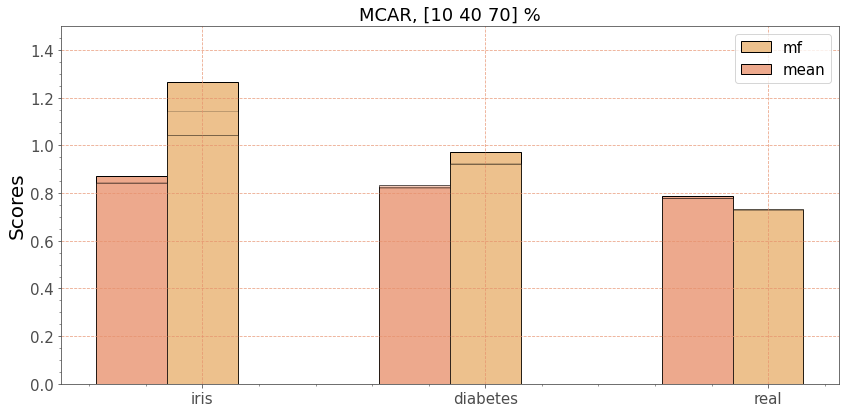

In [ ]:
# mode_f = 'bayesianRidge'#'mae'

for mode_f in modes:
    for mech_f in mechas:
        fig, ax = plt.subplots()
        for idx_miss, p_miss_f in enumerate(p_misses):

            # определяем переменные из params_grid (пр. строка)
            subgroup = lambda idx, imp_meth: (params_grid[idx][-3] == mech_f) and (float(params_grid[idx][-4]) == p_miss_f) and (params_grid[idx][-2] == imp_meth) and (params_grid[idx][-1] == mode_f)

            means = [res[1] for res in results]
            stds = [res[2] for res in results]
            labels = imputer_names

            means_s = []
            std_s = []
            imp_meth_s = []

            for imp_meth in imputer_names:
                means_s.append([mean for idx, mean in enumerate(means) if subgroup(idx, imp_meth)])
                std_s.append([std for idx, std in enumerate(stds) if subgroup(idx, imp_meth)])
                imp_meth_s.append([params_grid[idx][-1] for idx, mean in enumerate(means) if subgroup(idx, imp_meth)])

            x = np.arange(len(datasets))  # the label locations
            width = 0.25  # the width of the bars

            
            rects = []
            for idx, mean_i, std_i in zip(range(len(std_s)), means_s, std_s):
                rects.append(ax.bar(x - width * idx, mean_i, width, yerr = std_i, label=labels[idx], capsize=5, alpha=np.linspace(1, 0.2, len(p_misses))[idx_miss], color = colors[idx], edgecolor='black'))

            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('Scores')
            ax.set_title(f"{mech_f}, {(np.array(p_misses) * 100).astype(int)} %")
            ax.set_xticks(x)
            ax.set_ylim(0, 1.5)
            ax.set_xticklabels(datasets)
            ax.legend(imputer_names)
            ax.set_ylim(0)
            # for rect in rects:
            #     ax.bar_label(rect, padding=3)
        plt.savefig(f"figures/{mech_f}, {np.array(p_misses)*100} %, mode: {mode_f}_withRR.png", dpi=200)
fig.tight_layout()
plt.show()